In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import cftime as cftime
import fiona
import xarray as xr
import rasterio as rio
import rioxarray as rxr
from shapely.geometry import mapping
import geopandas as gpd

### Data preparation

In [2]:
def load_dataset(hazard_name,variable_name):
  # This function takes the input climate data for each hazard in the format of netcdf files. 
  # Two type of files are required: the netcdf of values above thresholds and the original climate variable
  # It loads the input data into a dataset with xarray and merges the daily climate data with the masks into a single dataset

  # Input variables:
  # model: corresponds to the name of the climate model or the reanalysis; it is used as part of the name of the file path
  # percentile: corresponds to the percentile applied in the threshold calculation; it is used as part of the name of the file path
  # variable: name of the climate variable; it is used as part of the name of the file path
  # mask name: name of the file mask (events above threshold); it is used as part of the name of the file path
  # values name: name of the file of the daily climate variable; it is used as part of the name of the file path
  # var name: name of the climate variable; it is used to access the variable in the xarray dataset
  # start_year: first year of the data; it is used as part of the name of the file path

  # Output variable:
  # an xarray dataset with updated names for the climate variable and the mask
  path_name='INPUT_data/'+hazard_name+'_mask.nc'
  path_values='INPUT_data/'+hazard_name+'_data.nc'
  var_mask=xr.open_dataset(str(path_name))
  var_values=xr.open_dataset(str(path_values))
  var_all=var_values.merge(var_mask)
  error_code='Full_dataset'
  return(var_all)


def day_sequence(var_df,start_date):
  #This functions creates a list of days from 1 to the end of the time period, useful to calculate distance in the time dimension
  # Slice the data to select only a timeframe, provide the start year (e.g., January 1, 2023)
  start_date = start_date.date()
  #print('the reference date is',start_date)
  list_of_days=[]
  for i in var_df.time:
    #print('the day counted is',i)
    time_difference = i - start_date
    #print('the time_difference is',time_difference)
    days_elapsed = time_difference.days
    #print('the days elapsed are',days_elapsed)
    days_elapsed_integer = int(days_elapsed)
    list_of_days.append(days_elapsed_integer)
  return(list_of_days)
  #print('the final integer is',days_elapsed_integer)

#This functions creates the days sequence with the progressive list of days produced in the day_sequence function
def time_preprocessing(var_ds,year_start='2018',year_end='2022'):#add a column with a progressive list of days
  var_ds=var_ds.sel(time=slice(str(year_start),str(year_end)))
  var_df=var_ds.to_dataframe().dropna().reset_index()
  var_df['time']=pd.to_datetime(var_df['time']).dt.date
  day_1=pd.to_datetime(str(year_start)+'-1-1')
  days_list=day_sequence(var_df,day_1)
  var_df['days']=days_list
  return(var_df)

#This function numbers cells in a progressive way, in order to have a unique reference ID for each cell
def cell_preprocessing(var_df):#add a column with a progressive list of cells and return also the df with the pairing
  var_df['cell'] = var_df.groupby(['lon', 'lat']).ngroup() + 1
  df_mapping=var_df[['cell','lon','lat']].drop_duplicates(subset='cell')
  return var_df,df_mapping
# to recrete the orginal coordinates: merged_df = prova.merge(wind_coords, on='cell', how='left')

#This function filters the mask file with minimum empirical thresholds. E.g., 20 mm/day fo precipitation, 13.9 m/s for wind
def filtering_thresholds(var_df,var_name,option):
  if option=='_NO_F_':
      return(var_df)
  #print(var_name)
  if 'WIND_SPEED' in var_name:
    threshold=13.9 #more than Gale force 7
    var_df[var_name]= var_df.apply(lambda row: 0 if row['WIND_SPEED'] < threshold else row[var_name], axis=1)
  if 'TOT_PREC' in var_name:
    threshold=20
    var_df[var_name]= var_df.apply(lambda row: 0 if row['TOT_PREC'] < threshold else row[var_name], axis=1)
  if 'T_2M' in var_name:
    threshold=273.15 # more than 0 ºC
    var_df[var_name]= var_df.apply(lambda row: 0 if row['T_2M'] < threshold else row[var_name], axis=1)
  return(var_df)

#This function sets the distance between two cells in x and y dimension to 1 for the CMCC dataset
def spatio_temporal_weight(cluster_df,lon_factor=35.335689,lat_factor=50.3778338): #these factors are specific for the dimension in degree of the remapped dataset
  cluster_df['new_lon']=cluster_df['lon']*lon_factor
  cluster_df['new_lat']=cluster_df['lat']*lat_factor
  min_lat=cluster_df['new_lat'].min()
  min_lon=cluster_df['new_lon'].min()
  cluster_df['new_lon']=cluster_df['new_lon']-min_lon
  cluster_df['new_lat']=cluster_df['new_lat']-min_lat
  return(cluster_df)

### Clustering single hazards

In [3]:
#This is the main DBSCAN function, and takes as input: 
#the mask data, 
#the variable name, 
#the multiplicative weight to be associated to days (increasing the distance between 2 days), 
#the epsilon parameter, 
#the min_element parameters and 
#the option to have a "_YES_F_' or "_NO_F_' data) choosing whether to filter or not climate inputs with empirical values

def clustering_application(var_df, var_name, day_weight, epsilon, min_elements, option):
    from sklearn.cluster import DBSCAN
    import numpy as np

    var_name_thres=var_name+'_MASK'

    # Filter the DataFrame
    var_df = filtering_thresholds(var_df, var_name_thres, option)
    grid_df=var_df.groupby(['lon','lat'])[var_name_thres].max().reset_index()
    grid_df.drop(columns=[var_name_thres],inplace=True)

    # Select relevant data
    cluster_df = var_df[var_df[var_name_thres] == 1]
    crop_df = var_df[var_df[var_name_thres] == 1]

    # Apply weights and prepare data for clustering
    cluster_df['days'] = (cluster_df['days'] + 1) * day_weight
    cluster_df = cluster_df[['lat', 'lon', 'days']]
    cluster_df = spatio_temporal_weight(cluster_df)
    cluster_df = cluster_df[['new_lat', 'new_lon', 'days']]
    X = cluster_df.to_numpy()

    # Fit DBSCAN
    dbscan_cluster_model = DBSCAN(eps=epsilon, min_samples=min_elements).fit(X)
    labels = dbscan_cluster_model.labels_
    #print('the labels are',labels)

    # Identify core points
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan_cluster_model.core_sample_indices_] = True
    #print('the core sample is',core_samples_mask)

    # Classify points
    crop_df['clusters'] = labels
    crop_df['core'] = core_samples_mask
    #print(crop_df.columns)

    return(crop_df,grid_df)

def single_hazard_clusters_update(df_single_cluster):
  # This function calculates the characteristics of the clusters and applies a spatial merge
  # Without the spatial merge, each day can have different clusters
  # given the extremely local application in Veneto, different clusters are merged together if they happen on the same day
  # in case of wider areas of application, this has to be removed to investigate spatially co-occurring hazards   
  df_char_temp=cluster_characteristics(df_single_cluster,'clusters')#calculates start day, end day, duration, extension of the original clusters
  df_char_temp=df_char_temp[df_char_temp['clusters']!=-1]
  df_preproc=merging_clusters(df_char_temp,0) #merging cluster function. delta=0 implies only a spatial merge
  df_single_cluster=df_single_cluster[df_single_cluster['clusters']!=-1]
  df_new_char=clustering_new_indexing(df_char_temp,df_preproc)#reindex clusters atfer merging
  df_merging=df_new_char[['clusters','new_clusters']]
  df_final_single_cluster=df_single_cluster.merge(df_merging,on='clusters')
  df_final_chars=cluster_characteristics(df_final_single_cluster,'new_clusters')#calculates new hazard characteristics after merge
  return(df_final_single_cluster,df_final_chars)

#Calculating the characteristics fo the clusters, to check for duration, intensity and fragmentation of the analysis. 
# Used later to merge events happening in the same day

def cluster_characteristics(df_cluster,cluster_col):
    df_cluster['time'] = pd.to_datetime(df_cluster['time'])
    # Get min and max time per cluster
    day_min = df_cluster.groupby(cluster_col)['time'].min().rename('day_start')
    day_max = df_cluster.groupby(cluster_col)['time'].max().rename('day_end')
    # Compute daily cell counts
    extension = df_cluster.groupby([cluster_col, 'time'])['lat'].count().rename('cells_per_day').reset_index() 
    # Aggregating cell count statistics
    extension_stats = extension.groupby(cluster_col)['cells_per_day'].agg(
        extension_mean='mean',
        extension_min='min',
        extension_max='max'
    )
    # Total elements per cluster
    total_cluster = df_cluster.groupby(cluster_col)['lat'].count().rename('total_elements')
    # Merging all statistics
    cluster_chars = (
        pd.concat([day_min, day_max, extension_stats, total_cluster], axis=1)
        .reset_index()
    )
    # Compute duration in days
    cluster_chars['duration'] = ((cluster_chars['day_end'] - cluster_chars['day_start']).dt.total_seconds() + 86400) / (24 * 60 * 60)
    # Compute date difference between consecutive clusters
    cluster_chars['date_difference'] = cluster_chars['day_start'].shift(-1) - cluster_chars['day_end']

    return cluster_chars

def merging_clusters(df,delta):
    #delta is the number of days in which i want to merge clusters. 
    #If delta is set to 0, the function merges clusters only spatially.
    merged_clusters = pd.DataFrame(columns=['clusters', 'day_start', 'day_end', 'new_order'])# Create an empty DataFrame to store the results
    new_order_counter = 1 # Initialize the new_order counter
    dfs = []# List to collect DataFrames for concatenation

    # Iterate through each row in the original DataFrame
    for index, row in df.iterrows():
        # Check if the current row overlaps with any existing merged clusters
        overlapping_clusters = merged_clusters[
            (merged_clusters['day_start'] <= row['day_end'] + pd.Timedelta(days=delta)) & 
            (merged_clusters['day_end'] >= row['day_start'] + pd.Timedelta(days=-delta))
        ]
        if overlapping_clusters.empty:
            # If no overlapping clusters, create a new merged cluster
            new_row = pd.DataFrame([{
                'clusters': row['clusters'],
                'day_start': row['day_start'],
                'day_end': row['day_end'],
                'new_order': new_order_counter
            }])
            dfs.append(new_row)
            new_order_counter += 1
        else:
            # If overlapping clusters, merge them and update the new_order for all involved clusters
            merged_clusters = merged_clusters[~merged_clusters['clusters'].isin(overlapping_clusters['clusters'])]
            new_row = pd.DataFrame([{
                'clusters': ', '.join(map(str, overlapping_clusters['clusters'].tolist() + [row['clusters']])),
                'day_start': min(overlapping_clusters['day_start'].min(), row['day_start']),
                'day_end': max(overlapping_clusters['day_end'].max(), row['day_end']),
                'new_order': new_order_counter
            }])
            dfs.append(new_row)
            new_order_counter += 1

        # Update merged_clusters DataFrame after processing each row
        if dfs:
            merged_clusters = pd.concat([merged_clusters] + dfs, ignore_index=True)
            dfs.clear()

    return merged_clusters

def clustering_new_indexing(df_char,df_processed):
  df_processed['new_cluster_label']=df_processed.index
  list_of_vals=[]
  for index,row in df_processed.iterrows():
    if type(row['clusters']) != int:
      cluster_values = row['clusters'].split(', ')
    else:
      cluster_values=[int(row['clusters'])]
    length=len(cluster_values)
    for i in range(0,length):
      list_of_vals.append(row['new_cluster_label'])
  df_char['new_clusters']=list_of_vals
  return(df_char)


def single_hazard_cluster(hazard,variable,weight,epsilon,minimum_points,option):
  var_ds=load_dataset(hazard,variable)
  var_ds2=time_preprocessing(var_ds)
  var_ds2,var_coords=cell_preprocessing(var_ds2)
  result_df,grid_df=clustering_application(var_ds2,variable,weight,epsilon,minimum_points,option)
  new_result,grid_df2=single_hazard_clusters_update(result_df)
  new_result.drop(columns='clusters',inplace=True)
  return(new_result,grid_df2)

In [4]:
heatwave,grid_heatwave=single_hazard_cluster('temp','T_2M',1,5,20,'_YES_F_')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['days'] = (cluster_df['days'] + 1) * day_weight
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['clusters'] = labels
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [5]:
precipitation,grid_precipitation=single_hazard_cluster('prec','TOT_PREC',10,11,100,'_YES_F_')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['days'] = (cluster_df['days'] + 1) * day_weight
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['clusters'] = labels
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [6]:
drought,grid_drought=single_hazard_cluster('drought','SPI_12',0.3,5,500,'_YES_F_')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['days'] = (cluster_df['days'] + 1) * day_weight
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['clusters'] = labels
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [7]:
wind,grid_wind=single_hazard_cluster('wind','WIND_SPEED',10,11,100,'_YES_F_')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['days'] = (cluster_df['days'] + 1) * day_weight
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['clusters'] = labels
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/1859189735.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

### Visualising single hazard clusters

In [8]:
def plot_3d_clusters_intensity(df, value_column,hazard, start_date=None, end_date=None, cmap="magma"):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import matplotlib.colors as mcolors
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.dates as mdates
    """
    Plots a 3D scatter plot of longitude, latitude, and time, 
    with points colored according to the values in a given column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing 'lon', 'lat', 'time', and the specified value column.
        value_column (str): The column to use for coloring the points.
        start_date (str, optional): Start date in 'YYYY-MM-DD' format.
        end_date (str, optional): End date in 'YYYY-MM-DD' format.
        cmap (str, optional): Colormap to use (default is "viridis").
    """
    # Convert 'time' column to datetime
    df["time"] = pd.to_datetime(df["time"])
    df=df[df['new_clusters']!=-1]

    # Apply date filter if provided
    if start_date:
        df = df[df["time"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["time"] <= pd.to_datetime(end_date)]

    # Get min and max values for normalization
    vmin = df[value_column].min()
    vmax = df[value_column].max()

    # Define colormap
    
    if hazard!='Drought':
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap(cmap)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=0)
        cmap = plt.get_cmap(cmap+"_r")

    # Plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot
    sc = ax.scatter(df["lon"], df["lat"], df["time"].map(mdates.date2num), 
                    c=df[value_column], cmap=cmap, norm=norm, alpha=0.7)

    # Labels and formatting
    ax.invert_xaxis()
    ax.set_xlabel("Longitude", labelpad=20)
    ax.invert_yaxis()
    ax.set_ylabel("Latitude", labelpad=20)
    #ax.set_zlabel("Time", labelpad=10)
    ax.set_title(f"3D Multi-Hazard clusters - {hazard}", pad=20)
    ax.view_init(elev=20, azim=60)

    # Format Z-axis to display real dates
    ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.zaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    plt.setp(ax.get_zticklabels(), rotation=15, ha="right")
    ax.tick_params(axis='z', pad=35)  # Add padding to the Z-axis tick labels
    ax.zaxis.labelpad = 10  # Add padding to the Z-axis label

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label(value_column)

    plt.xticks(rotation=45)
    plt.show()

def plot_3d_clusters(df, hazard,cluster_column='new_clusters',start_date=None, end_date=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import matplotlib.colors as mcolors
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.dates as mdates
    """
    Plots a 3D scatter plot of longitude, latitude, and time, 
    with points colored according to the 'clusters' column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing 'lon', 'lat', 'time', and 'clusters'.
        start_date (str, optional): Start date in 'YYYY-MM-DD' format.
        end_date (str, optional): End date in 'YYYY-MM-DD' format.
    """
    # Convert 'time' column to datetime
    df["time"] = pd.to_datetime(df["time"])
    df=df[df['new_clusters']!=-1]

    # Apply date filter if provided
    if start_date:
        df = df[df["time"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["time"] <= pd.to_datetime(end_date)]

    # Define colors for clusters
    unique_clusters = df[cluster_column].unique()
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Get distinct colors
    cluster_color_map = {c: colors(i) for i, c in enumerate(unique_clusters)}

    # Plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection="3d")
    #ax = fig.add_axes([0.6, 0.3, 0.35, 0.35], projection='3d')

    # Scatter plot
    for cluster in unique_clusters:
        cluster_df = df[df[cluster_column] == cluster]
        ax.scatter(cluster_df["lon"], cluster_df["lat"], cluster_df["time"].map(mdates.date2num), 
                   color=cluster_color_map[cluster], label=f"Cluster {cluster}", alpha=0.4)

    # Labels and formatting
    ax.invert_xaxis()
    ax.set_xlabel("Longitude", labelpad=20)
    ax.invert_yaxis()
    ax.set_ylabel("Latitude", labelpad=20)
    #ax.set_zlabel("Time", labelpad=10)
    ax.set_title("3D Multi-Hazard Clustering - "+hazard, pad=20)
    #ax.set_title("3D Multi-Hazard Clustering")
    ax.view_init(elev=20, azim=60)

    
    # Format Z-axis to display real dates
    ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #ax.zaxis.set_major_locator(mdates.AutoDateLocator())
    ax.zaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    # Rotate Z-axis labels to prevent overlap
    #ax.zaxis.labelpad = 25
    plt.setp(ax.get_zticklabels(), rotation=15, ha="right")
    ax.tick_params(axis='z', pad=35)  # Add padding to the Z-axis tick labels
    ax.zaxis.labelpad = 10  # Add padding to the Z-axis label

    plt.xticks(rotation=45)
    ax.legend()
    plt.show()

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/4219276782.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Get distinct colors


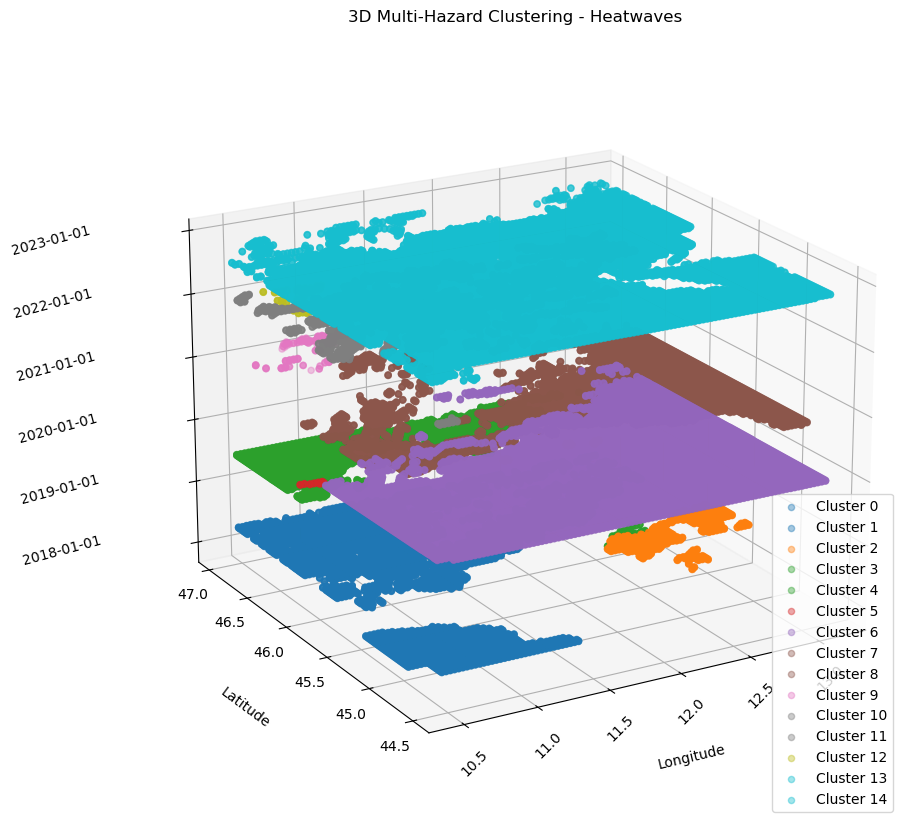

In [9]:
plot_3d_clusters(heatwave, 'Heatwaves',start_date="2018-01-01", end_date="2022-10-30")

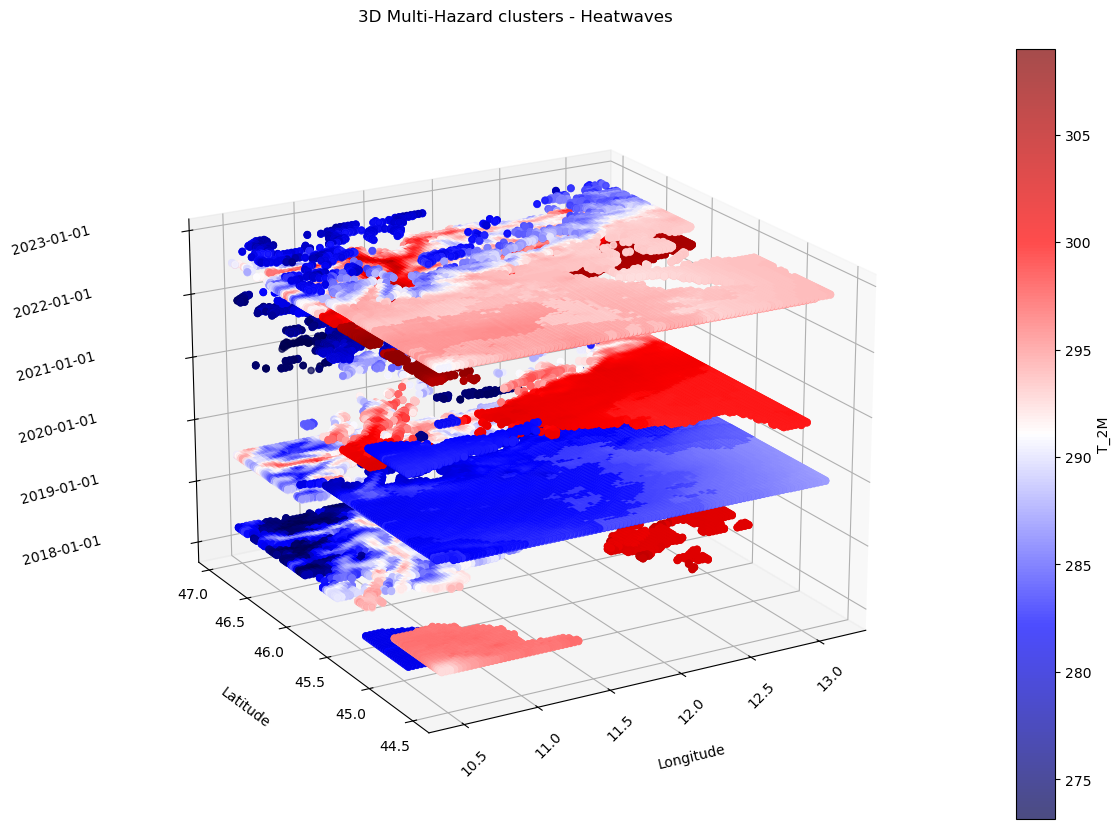

In [10]:
plot_3d_clusters_intensity(heatwave,'T_2M','Heatwaves',start_date="2018-01-01", end_date="2022-10-31",cmap='seismic')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/4219276782.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Get distinct colors


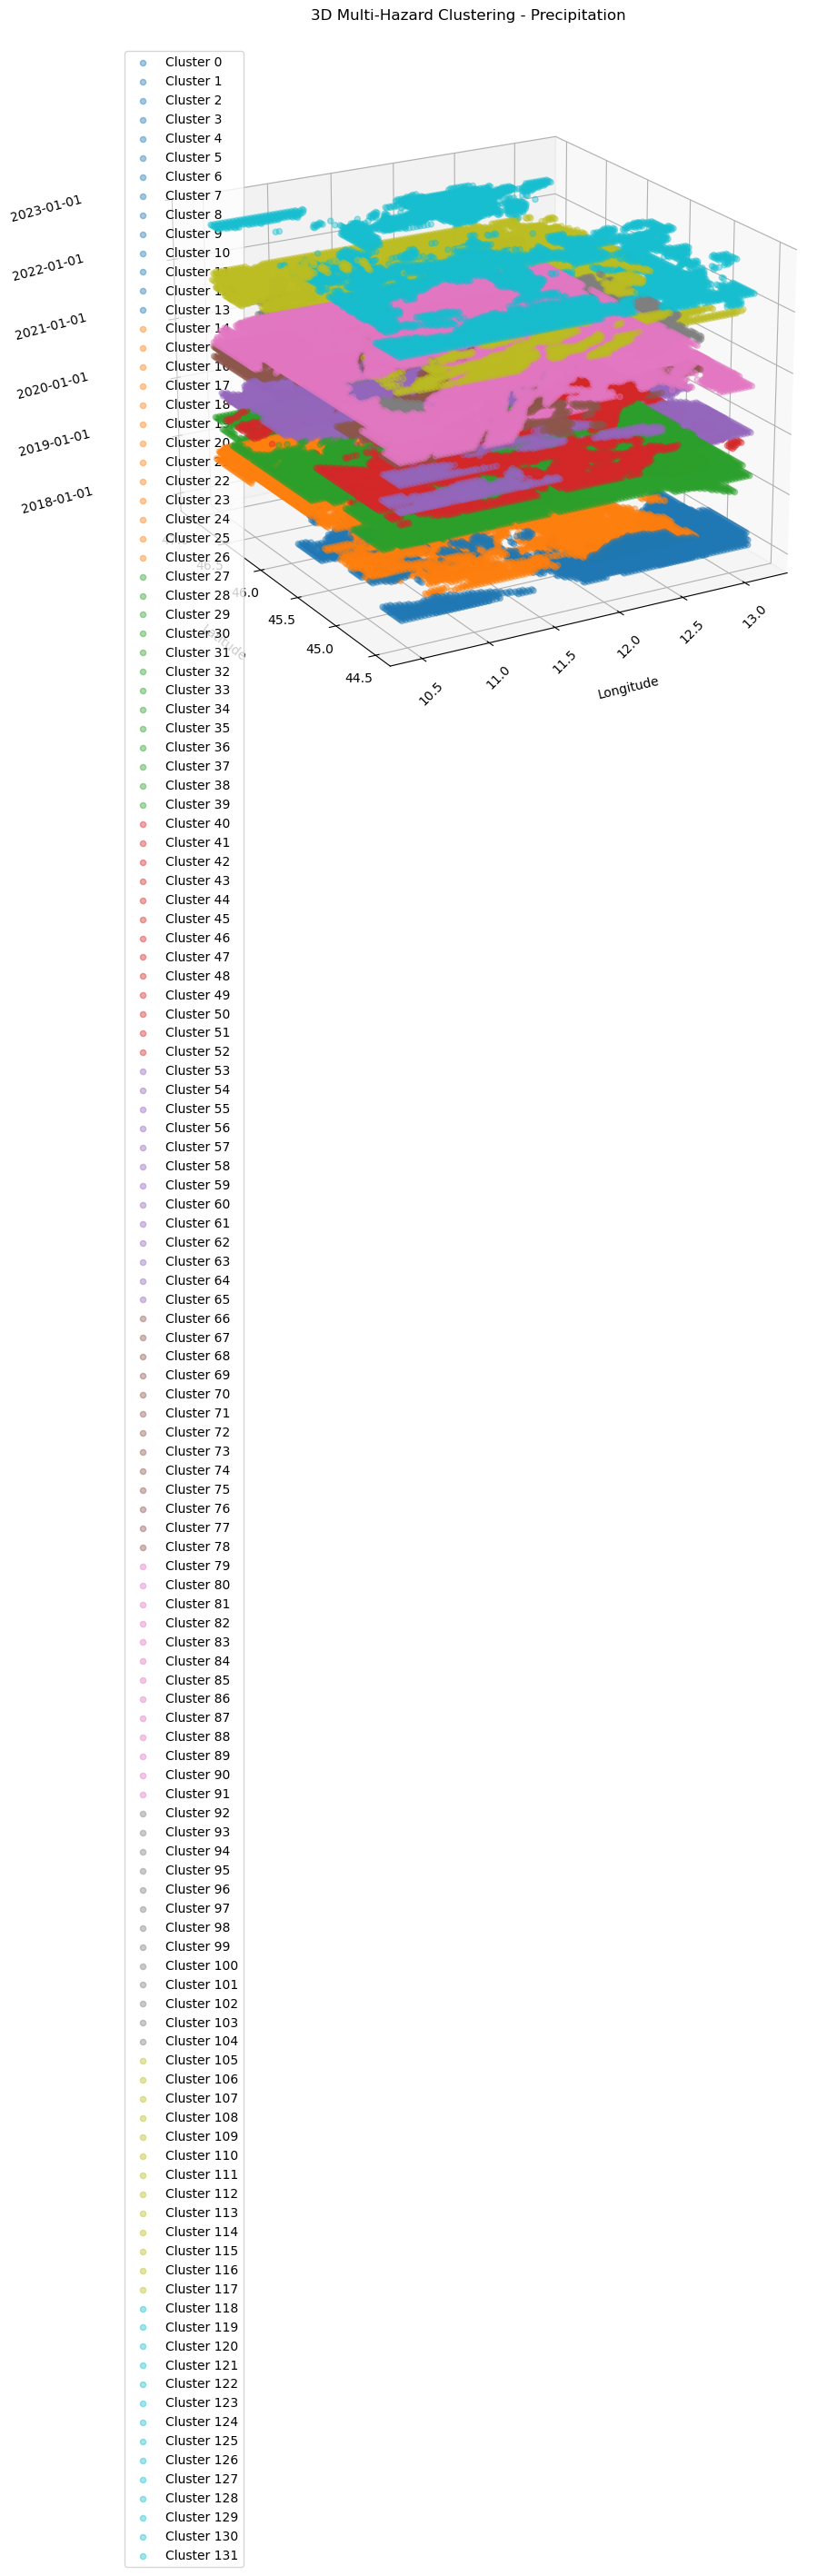

In [11]:
plot_3d_clusters(precipitation, 'Precipitation','new_clusters',start_date="2018-01-01", end_date="2022-08-31")

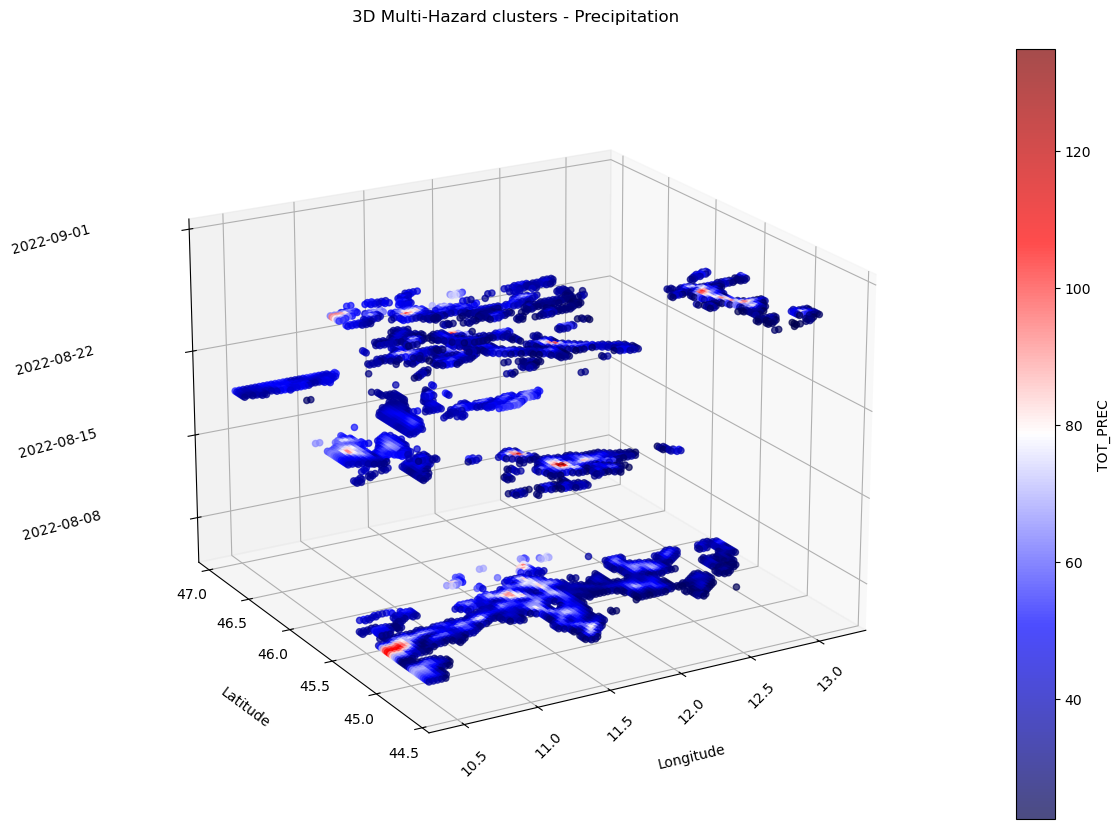

In [12]:
plot_3d_clusters_intensity(precipitation, 'TOT_PREC','Precipitation',start_date="2022-08-01", end_date="2022-08-31",cmap='seismic')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/4219276782.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Get distinct colors


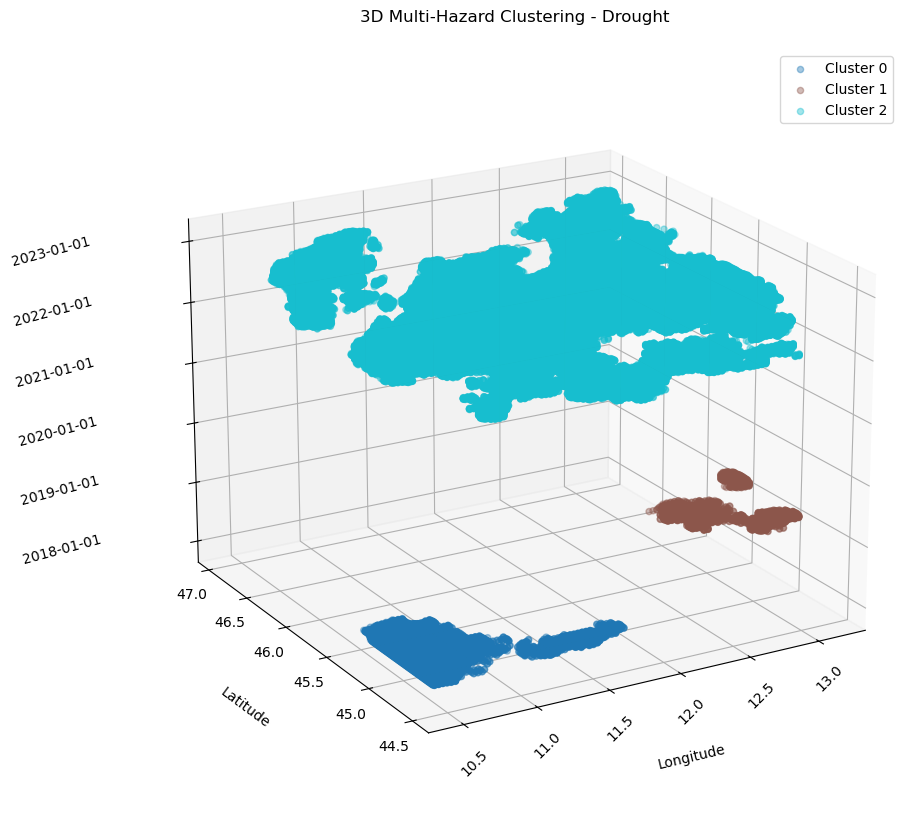

In [13]:
plot_3d_clusters(drought, 'Drought','new_clusters',start_date="2018-01-01", end_date="2022-12-31")

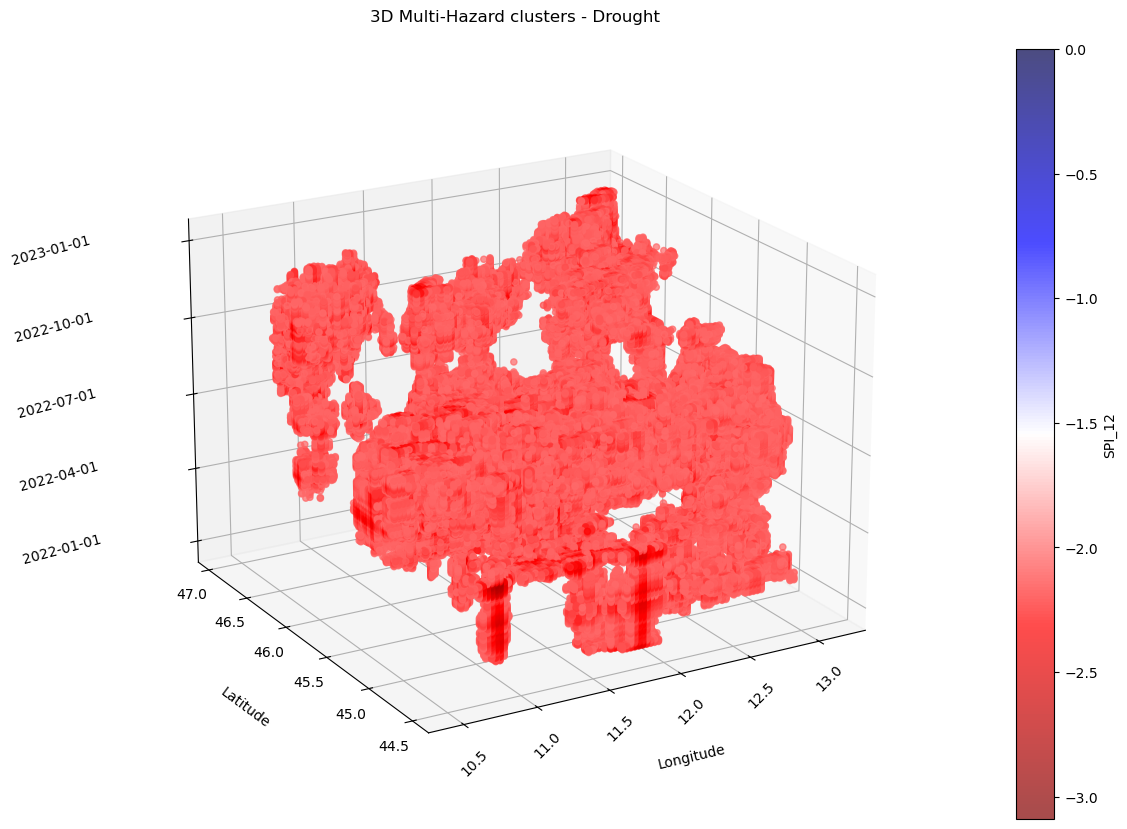

In [14]:
plot_3d_clusters_intensity(drought, 'SPI_12','Drought',start_date="2022-01-01", end_date="2022-12-31",cmap='seismic')

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/4219276782.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Get distinct colors


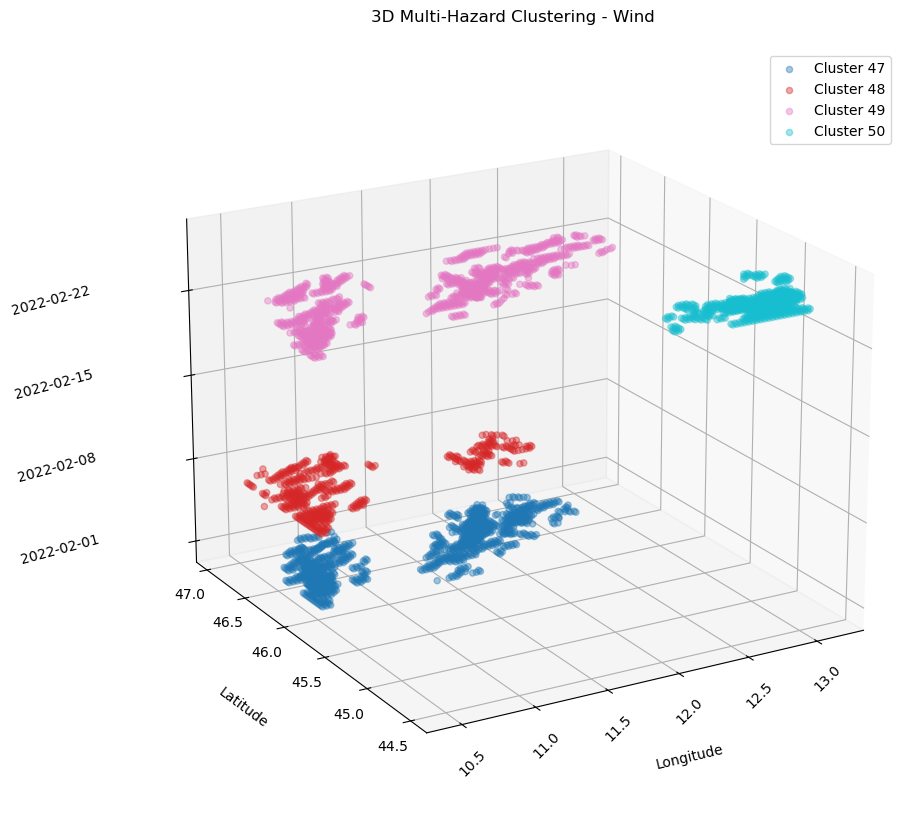

In [15]:
plot_3d_clusters(wind, 'Wind','new_clusters',start_date="2022-02-01", end_date="2022-02-28")

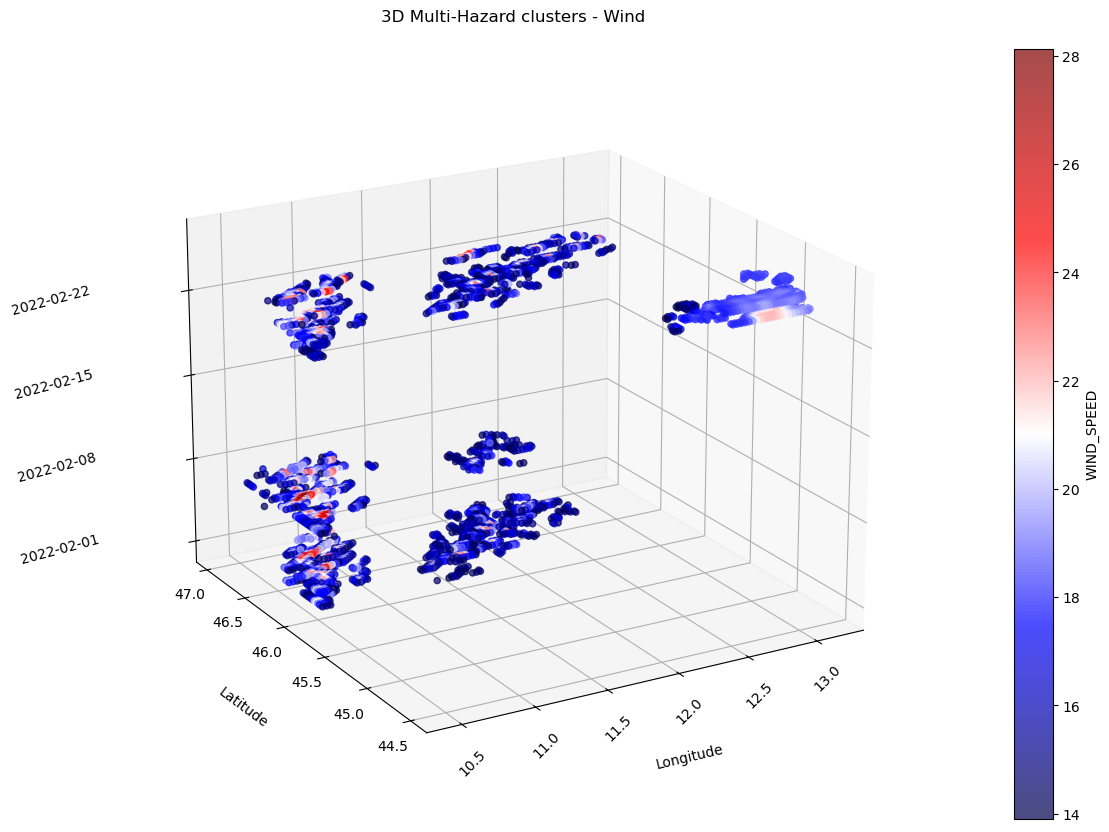

In [16]:
plot_3d_clusters_intensity(wind, 'WIND_SPEED','Wind',start_date="2022-02-01", end_date="2022-02-28",cmap='seismic')

### Multi-hazard events

In [17]:
def compound_events_creation(df):
    df['prec_wind'] = np.where(df['WIND_SPEED'].isnull() | df['TOT_PREC'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + '_'+df['year'].astype(str))
    df['prec_drought'] = np.where(df['SPI_12'].isnull() | df['TOT_PREC'].isnull(),
                           np.nan,
                           'd_' + df['drought_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + '_'+df['year'].astype(str))
    df['prec_heat'] = np.where(df['T_2M'].isnull() | df['TOT_PREC'].isnull(),
                           np.nan,
                           'h_' + df['temp_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) +'_'+ df['year'].astype(str))
    df['drought_wind'] = np.where(df['WIND_SPEED'].isnull() | df['SPI_12'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'd_' + df['drought_clusters'].astype(str) + '_'+df['year'].astype(str))
    df['drought_heat'] = np.where(df['SPI_12'].isnull() | df['T_2M'].isnull(),
                           np.nan,
                           'd_' + df['drought_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str) + '_'+df['year'].astype(str))
    df['heat_wind'] = np.where(df['WIND_SPEED'].isnull() | df['T_2M'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str) + '_'+df['year'].astype(str))
    df['prec_wind_heat'] = np.where(df['WIND_SPEED'].isnull() | df['TOT_PREC'].isnull() | df['T_2M'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str)+'_'+df['year'].astype(str))
    df['prec_wind_drought'] = np.where(df['WIND_SPEED'].isnull() | df['TOT_PREC'].isnull() | df['SPI_12'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + 'd_' + df['drought_clusters'].astype(str)+'_'+df['year'].astype(str))
    df['prec_drought_heat'] = np.where(df['WIND_SPEED'].isnull() | df['SPI_12'].isnull() | df['T_2M'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'd_' + df['drought_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str)+'_'+df['year'].astype(str))
    df['drought_wind_heat'] = np.where(df['SPI_12'].isnull() | df['TOT_PREC'].isnull() | df['T_2M'].isnull(),
                           np.nan,
                           'd_' + df['drought_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str)+'_'+df['year'].astype(str))
    df['prec_wind_heat_drought'] = np.where(df['WIND_SPEED'].isnull() | df['TOT_PREC'].isnull() | df['T_2M'].isnull() | df['SPI_12'].isnull(),
                           np.nan,
                           'w_' + df['wind_clusters'].astype(str) + 'p_' + df['prec_clusters'].astype(str) + 'h_' + df['temp_clusters'].astype(str)+'d_' + df['drought_clusters'].astype(str)+'_'+df['year'].astype(str))
    return(df)

def merge_single_hazards(df_prec,df_wind,df_heat,df_drought):
    df_prec.rename(columns={'new_clusters':'prec_clusters'},inplace=True)
    df_wind.rename(columns={'new_clusters':'wind_clusters'},inplace=True)
    df_drought.rename(columns={'new_clusters':'drought_clusters'},inplace=True)
    df_heat.rename(columns={'new_clusters':'temp_clusters'},inplace=True)
    df_prec.drop(columns=['days','cell','core'],inplace=True)
    df_wind.drop(columns=['days','cell','core'],inplace=True)
    df_drought.drop(columns=['days','cell','core'],inplace=True)
    df_heat.drop(columns=['days','cell','core'],inplace=True)
    df_merged=df_prec.merge(df_wind,on=['time','lon','lat'],how='outer')
    df_merged=df_merged.merge(df_heat,on=['time','lon','lat'],how='outer')
    df_merged=df_merged.merge(df_drought,on=['time','lon','lat'],how='outer')
    df_merged['year']=df_merged['time'].dt.year
    #print('the merged dataset columns are: ',df_merged.columns)
    return(df_merged)

def compound_events_flattening(df):
    df2 = df.drop(columns=['time', 'year', 'TOT_PREC', 'T_2M', 'SPI_12', 'WIND_SPEED'])
    flattened_multi_hazards = df2.groupby(['lon', 'lat']).count().reset_index()

    # Extract single and multi-hazard columns
    single_hazards = flattened_multi_hazards[['lon', 'lat', 'prec_clusters', 'wind_clusters', 'temp_clusters', 'drought_clusters']]
    multi_hazards_only = flattened_multi_hazards[['lon', 'lat', 'prec_wind', 'prec_drought', 'prec_heat', 'drought_wind', 
                                                  'drought_heat', 'heat_wind', 'prec_wind_heat', 'prec_wind_drought', 
                                                  'prec_drought_heat', 'drought_wind_heat', 'prec_wind_heat_drought']]

    # Assign max column name, but set 'no_hazard' if max value is 0
    single_hazards['class'] = single_hazards.iloc[:, 2:].apply(lambda row: row.idxmax() if row.max() > 0 else 'no_hazard', axis=1)
    multi_hazards_only['class'] = multi_hazards_only.iloc[:, 2:].apply(lambda row: row.idxmax() if row.max() > 0 else 'no_hazard', axis=1)

    return flattened_multi_hazards, single_hazards, multi_hazards_only

def multi_hazarding(prec_cluster,wind_cluster,heat_cluster,drought_cluster):
    multi_hazard_df=merge_single_hazards(prec_cluster,wind_cluster,heat_cluster,drought_cluster)
    #print('the multi-hazard columns are',multi_hazard_df.columns)
    compound_events_df=compound_events_creation(multi_hazard_df)
    flat_mh,flat_sh,flat_mh_only=compound_events_flattening(compound_events_df)
    return(compound_events_df,flat_mh,flat_sh,flat_mh_only)

def add_time_lag_rows(df,n,cluster_name,hazard):
    """
    Adds n rows with a time lag to the DataFrame. Each new row has the same values 
    except for the date, which is incremented by i (1 to n).
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    n (int): The number of new rows to create for each row in the original DataFrame.
    cluster_name (string): name of the column with single hazard clusters
    hazard (string): name of the hazard (e.g., drought, heat, prec, wind)
    
    Returns:
    - pd.DataFrame: The DataFrame with additional rows.
    """
    # Empty list to hold the new rows
    new_rows = []
    df['time']=pd.to_datetime(df['time'])
    if 'compound_'+hazard+'_check' in df.columns:
        df.drop(columns=['compound_'+hazard+'_check'],inplace=True)
    
    # Iterate over each row in the original DataFrame
    for _, row in df.iterrows():
        for i in range(1, n + 1):
            # Create a new row with the same values as the original row
            new_row = row.copy()
            
            # Increment the date by i days
            new_row['time'] = pd.to_datetime(new_row['time']) + pd.Timedelta(days=i)
            
            # Append the new row to the new rows list
            new_rows.append(new_row)
    
    # Create a new DataFrame from the list of new rows
    df_new = pd.DataFrame(new_rows)
    print('The columns of df_new are: ',df_new.columns)
    # Concatenate the original DataFrame with the new DataFrame
    df_combined = pd.concat([df, df_new], ignore_index=True)
    df_combined['time'] = pd.to_datetime(df_combined['time'])  # Ensure date is in datetime format
    print('The size before the dropping of duplicates is',df_combined.shape[0])
    print('The columns of df_combined are: ',df_combined.columns)
    #print(df_combined)
    df_cleaned = df_combined.drop_duplicates(subset=['lat', 'lon', 'time',cluster_name], keep='first') #drop duplicates
    print('The columns of df_clean are: ',df_cleaned.columns)
    print('The size after the dropping of duplicates is',df_cleaned.shape[0])
    df_2=df.copy()
    df_2['compound_'+hazard+'_check']=1
    df_cleaned=df_cleaned.merge(df_2[['lat','lon','time','compound_'+hazard+'_check']],on=['lat','lon','time'],how='outer')
    print('The size after adding of check of compoundness is',df_cleaned.shape[0])
    return df_cleaned

def consecutive_hazards(df_prec,df_wind,df_heat,df_drought,n):
    """creates the consecutive event dataset
    """
    prec_lag_days=add_time_lag_rows(df_prec, n,'prec_clusters','prec')
    wind_lag_days=add_time_lag_rows(df_wind, n,'wind_clusters','wind')
    heat_lag_days=add_time_lag_rows(df_heat, n,'temp_clusters','heat')
    drought_lag_days=add_time_lag_rows(df_drought, n,'drought_clusters','drought')
    
    heat_1days_first=heat_lag_days.groupby(['lon','lat','temp_clusters'])['time'].min().reset_index(name='first_day_temp')
    heat_1days_last=heat_lag_days.groupby(['lon','lat','temp_clusters'])['time'].max().reset_index(name='last_day_temp')
    prec_1days_first=prec_lag_days.groupby(['lon','lat','prec_clusters'])['time'].min().reset_index(name='first_day_prec')
    prec_1days_last=prec_lag_days.groupby(['lon','lat','prec_clusters'])['time'].max().reset_index(name='last_day_prec')
    wind_1days_first=wind_lag_days.groupby(['lon','lat','wind_clusters'])['time'].min().reset_index(name='first_day_wind')
    wind_1days_last=wind_lag_days.groupby(['lon','lat','wind_clusters'])['time'].max().reset_index(name='last_day_wind')
    drought_1days_first=drought_lag_days.groupby(['lon','lat','drought_clusters'])['time'].min().reset_index(name='first_day_drought')
    drought_1days_last=drought_lag_days.groupby(['lon','lat','drought_clusters'])['time'].max().reset_index(name='last_day_drought')
    
    drought_lag_days=drought_lag_days.merge(drought_1days_first,on=['lon','lat','drought_clusters'],how='outer')
    drought_lag_days=drought_lag_days.merge(drought_1days_last,on=['lon','lat','drought_clusters'],how='outer')
    heat_lag_days=heat_lag_days.merge(heat_1days_first,on=['lon','lat','temp_clusters'],how='outer')
    heat_lag_days=heat_lag_days.merge(heat_1days_last,on=['lon','lat','temp_clusters'],how='outer')
    prec_lag_days=prec_lag_days.merge(prec_1days_first,on=['lon','lat','prec_clusters'],how='outer')
    prec_lag_days=prec_lag_days.merge(prec_1days_last,on=['lon','lat','prec_clusters'],how='outer')
    wind_lag_days=wind_lag_days.merge(wind_1days_first,on=['lon','lat','wind_clusters'],how='outer')
    wind_lag_days=wind_lag_days.merge(wind_1days_last,on=['lon','lat','wind_clusters'],how='outer')
    

    consecutive_hazards=heat_lag_days.merge(drought_lag_days,on=['lon','lat','time'],how='outer')
    consecutive_hazards=consecutive_hazards.merge(wind_lag_days,on=['lon','lat','time'],how='outer')
    consecutive_hazards=consecutive_hazards.merge(prec_lag_days,on=['lon','lat','time'],how='outer')
    consecutive_hazards['year']=consecutive_hazards['time'].dt.year
    consecutive_hazards=compound_events_creation(consecutive_hazards)
    consecutive_hazards=clean_hazard_combinations(consecutive_hazards)
    return(consecutive_hazards)

def clean_hazard_combinations(df):
    """Cleans the consecutive datasets from tail events, i.e. events in which the time lag creates a tail of new hazards that do not overlap with other existing events
    """
    hazard_pairs = {
        'prec_wind': ('last_day_prec', 'last_day_wind'),
        'prec_drought': ('last_day_prec', 'last_day_drought'),
        'prec_heat': ('last_day_prec', 'last_day_temp'),
        'drought_wind': ('last_day_drought', 'last_day_wind'),
        'drought_heat': ('last_day_drought', 'last_day_temp'),
        'heat_wind': ('last_day_temp', 'last_day_wind'),
        'prec_wind_heat': ('last_day_prec', 'last_day_wind', 'last_day_temp'),
        'prec_wind_drought': ('last_day_prec', 'last_day_wind', 'last_day_drought'),
        'prec_drought_heat': ('last_day_prec', 'last_day_drought', 'last_day_temp'),
        'drought_wind_heat': ('last_day_drought', 'last_day_wind', 'last_day_temp'),
        'prec_wind_heat_drought': ('last_day_prec', 'last_day_wind', 'last_day_temp', 'last_day_drought'),
    }

    for hazard_col, last_day_cols in hazard_pairs.items():
        mask = df["time"] > df[list(last_day_cols)].max(axis=1)
        df.loc[mask, hazard_col] = np.nan  # Set to NaN if 'time' is later than all corresponding last_day_* columns
    return df    
    

def load_climate():
    """Reloads climate data with conditions in the real date 
    """
    import pandas as pd
    import geopandas as gpd
    temp=xr.open_dataset('INPUT_data/temp_data.nc')
    drought=xr.open_dataset('INPUT_data/drought_data.nc')
    prec=xr.open_dataset('INPUT_data/prec_data.nc')
    wind=xr.open_dataset('INPUT_data/wind_data.nc')
    df_prec=prec['TOT_PREC'].to_dataframe().reset_index()
    df_temp=temp['T_2M'].to_dataframe().reset_index()
    df_wind=wind['WIND_SPEED'].to_dataframe().reset_index()
    df_drought=drought['SPI_12'].to_dataframe().reset_index()
    df_prec['time']=pd.to_datetime(df_prec['time']).dt.date
    df_temp['time']=pd.to_datetime(df_temp['time']).dt.date
    df_wind['time']=pd.to_datetime(df_wind['time']).dt.date
    df_drought['time']=pd.to_datetime(df_drought['time']).dt.date
    df_tot=df_prec.merge(df_temp,on=['lon','lat','time'],how='outer')
    df_tot=df_tot.merge(df_wind,on=['lon','lat','time'],how='outer')
    df_tot=df_tot.merge(df_drought,on=['lon','lat','time'],how='outer')
    return(df_tot)

def pairing_climate(df_hazards,df_climate):
    df_hazards.drop(columns=['TOT_PREC','T_2M','WIND_SPEED','SPI_12','TOT_PREC_MASK','T_2M_MASK','WIND_SPEED_MASK','SPI_12_MASK'],inplace=True)
    df_hazards['time']=pd.to_datetime(df_hazards['time']).dt.date
    df_hazards=df_hazards.merge(df_climate,on=['time','lon','lat'])
    return(df_hazards)

### Graphs and figures

In [18]:
!pip install cartopy

In [19]:
def plot_multi_hazards_compound(df,shapefile, scenario):
    import xarray as xr
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import geopandas as gpd
    from cartopy.io.shapereader import Reader
    from cartopy.feature import ShapelyFeature
    # Define colors for each class
    class_colors = {
        'prec_wind': 'navy',
        'prec_drought': 'forestgreen',
        'prec_heat': 'orchid',
        'drought_wind': 'gold',
        'drought_heat': 'crimson',
        'heat_wind': 'coral',
        'prec_wind_heat': 'pink',
        'prec_wind_drought': 'cyan',
        'prec_drought_heat': 'yellow',
        'drought_wind_heat': 'magenta',
        'prec_wind_heat_drought': 'black',
        'no_hazards':'white'
}


    #shapefile = 'Limiti/Regioni/Reg01012024_g_WGS84.shp'
    gdf = gpd.read_file(shapefile)
    gdf = gdf.to_crs(epsg=4326)
    # Plotting
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12.5, 9.6))
    # Add borders and features
    #ax.add_feature(cfeature.BORDERS, linestyle=':')
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    #ax.add_feature(cfeature.LAKES, alpha=0.5)
    #ax.add_feature(cfeature.RIVERS)
    # Add Veneto borders
    gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, linestyle='-',transform=ccrs.PlateCarree())
    # Set the extent to focus on Northeast Italy
    ax.set_extent([10.3, 13.3, 44.4, 47.1], crs=ccrs.PlateCarree())
    # Add gridlines and labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--')
    gridlines.top_labels = False
    gridlines.right_labels = False

    # Plot each class with a different color
    for class_name, color in class_colors.items():
        class_data = df[df['class'] == class_name]
        ax.scatter(class_data['lon'], class_data['lat'], c=color, label=class_name, s=3)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Set title
    plt.title('Predominant Class by Location '+scenario)
    plt.savefig('OUTPUT/'+scenario+'.png')

    plt.show()

In [20]:
compound_events_df,flat_mh,flat_sh,flat_mh_only=multi_hazarding(precipitation,wind,heatwave,drought)

/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/535285749.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hazards['class'] = single_hazards.iloc[:, 2:].apply(lambda row: row.idxmax() if row.max() > 0 else 'no_hazard', axis=1)
/var/folders/yx/tl4bksqx70gc81vxn7h5jtl40000gn/T/ipykernel_16127/535285749.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_hazards_only['class'] = multi_hazards_only.iloc[:, 2:].apply(lambda row: row.idxmax() if row.max() > 0 else 'no_hazard', ax

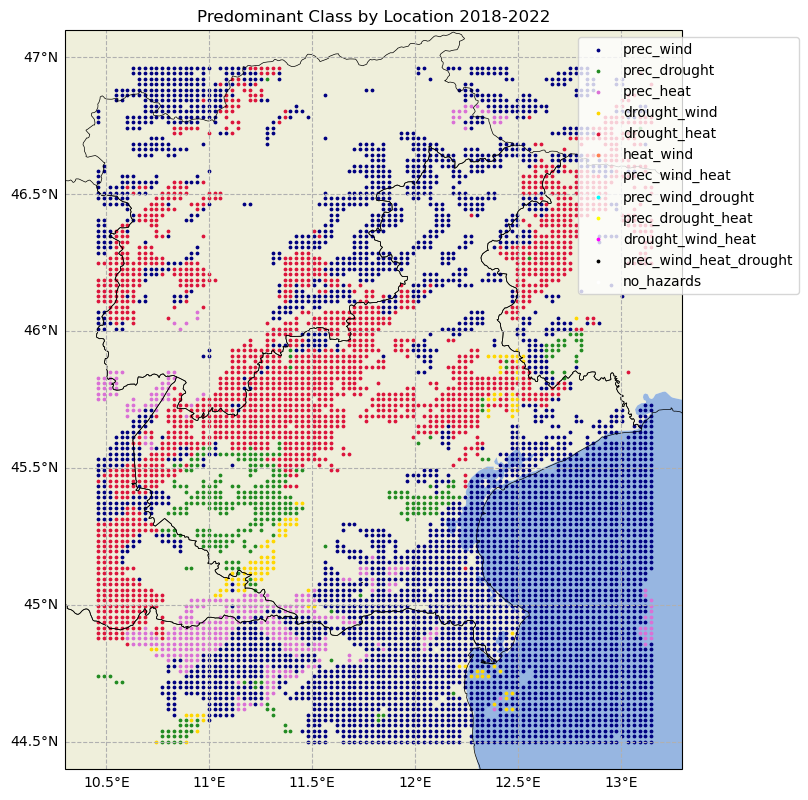

In [21]:
# This function is only for testing purposes: it runs on only 5 years of data
# to have a robust ana;ysis of multi-hazard combinations at least 30 years fo data are needed

plot_multi_hazards_compound(flat_mh_only,'INPUT_data/Limiti/Regioni/Reg01012024_g_WGS84.shp','2018-2022')

In [ ]:
# This function is working with the new precipitation, wind, heatwave and drought dataframes, 
# with renamed columns for the identified clusters after the compound event analysis
time_lag7=consecutive_hazards(precipitation,wind,heatwave,drought,7)

The columns of df_new are:  Index(['time', 'lon', 'lat', 'TOT_PREC', 'TOT_PREC_MASK', 'prec_clusters'], dtype='object')
The size before the dropping of duplicates is 1507336
The columns of df_combined are:  Index(['time', 'lon', 'lat', 'TOT_PREC', 'TOT_PREC_MASK', 'prec_clusters'], dtype='object')
The columns of df_clean are:  Index(['time', 'lon', 'lat', 'TOT_PREC', 'TOT_PREC_MASK', 'prec_clusters'], dtype='object')
The size after the dropping of duplicates is 1385993
The size after adding of check of compoundness is 1385993
The columns of df_new are:  Index(['time', 'lon', 'lat', 'WIND_SPEED', 'WIND_SPEED_MASK', 'wind_clusters'], dtype='object')
The size before the dropping of duplicates is 406112
The columns of df_combined are:  Index(['time', 'lon', 'lat', 'WIND_SPEED', 'WIND_SPEED_MASK', 'wind_clusters'], dtype='object')
The columns of df_clean are:  Index(['time', 'lon', 'lat', 'WIND_SPEED', 'WIND_SPEED_MASK', 'wind_clusters'], dtype='object')
The size after the dropping of dupli

In [ ]:
time_lag7.columns

In [ ]:
df_climate=load_climate()
consecutive_events_tl7=pairing_climate(time_lag7,df_climate)

In [ ]:
consecutive_events_tl7

In [ ]:
consecutive_events_tl7.columns

In [ ]:
flat_mh_tl7,flat_sh_tl7,flat_mh_tl7=compound_events_flattening(consecutive_events_tl7)

In [ ]:
flat_mh_tl7

In [ ]:
# This function is only for testing purposes: it runs on only 5 years of data
# to have a robust ana;ysis of multi-hazard combinations at least 30 years fo data are needed

plot_multi_hazards_compound(flat_mh_tl7,'INPUT_data/Limiti/Regioni/Reg01012024_g_WGS84.shp','2018-2022')

# Attributes for clusters

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

def filter_veneto(df, shapefile_path, name_column='tipo_p'):
    """
    Filters the input DataFrame to only include points within the Veneto region,
    and adds a column with landscape name.

    Parameters:
    - df: pandas.DataFrame with 'lon' and 'lat' columns
    - shapefile_path: path to the Veneto shapefile (should be in EPSG:4326 or reprojected)
    - name_column: name of the column in shapefile for province/landscape (e.g., 'tipo_p')

    Returns:
    - filtered DataFrame with a new column (landscape) for the landscape info within the Veneto Region
    """
    # Load shapefile as GeoDataFrame
    veneto_gdf = gpd.read_file(shapefile_path)
    veneto_gdf = veneto_gdf.to_crs(epsg=4326)  # Ensure CRS is WGS84

    # Create GeoDataFrame from input df
    geometry = gpd.points_from_xy(df['lon'], df['lat'])
    df_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    # Spatial join: match points to polygons
    joined = gpd.sjoin(df_gdf, veneto_gdf[[name_column, 'geometry']], how='inner', predicate='within')

    # Rename the joined name column to avoid confusion
    joined = joined.rename(columns={name_column: 'landscape'})

    return joined.drop(columns=['geometry','index_right'])

In [ ]:
filter_veneto(precipitation,'boundaries/c1103018013_ricognizionepaesaggivenetoperimetri.shp')

In [ ]:
precipitation.prec_clusters

In [ ]:
def total_extension(df,cluster_name,name):
    """
    Calculates the total extension (in days) of each cluster at each location (lon, lat),
    based on the number of days with a valid TOT_PREC_MASK value.

    Parameters:
    - df: DataFrame containing at least ['lon', 'lat', cluster_name, name]
    - cluster_name: str, name of the column representing the ID of the cluster/group (e.g., prec_clusters)
    - name: str, name of the column representing the variable of the cluster (e.g., TOT_PREC)

    Returns:
    - A DataFrame with [cluster_name, 'total_extension']
    """
    total_extension_df=df.groupby([cluster_name])[name].size().reset_index(name='total_extension')
    return(total_extension_df)

def duration(df, cluster_name, date_column='time'):
    """
    Calculates duration per cluster based on min and max date.

    Parameters:
    - df: DataFrame with at least [cluster_name, date_column]
    - cluster_name: str, column name identifying clusters (e.g., 'landscape')
    - date_column: str, name of the date column (default: 'date')

    Returns:
    - DataFrame with cluster_name, min_date, max_date, and duration (days)
    """
    # Ensure date column is datetime
    df[date_column] = pd.to_datetime(df[date_column])

    result = (
        df.groupby(cluster_name)[date_column]
          .agg(min_date='min', max_date='max')
          .reset_index()
    )
    
    result['duration'] = (result['max_date'] - result['min_date']).dt.days + 1
    
    return result

def spatial_extension(df, cluster_name):
    """
    Calculates the number of unique (lon, lat) cells involved in each cluster.

    Parameters:
    - df: DataFrame containing ['lon', 'lat', cluster_name]
    - cluster_name: str, column name representing the cluster ID

    Returns:
    - A DataFrame with [cluster_name, 'total_cells']
    """
    total_cells_df = (
        df.drop_duplicates(subset=['lon', 'lat', cluster_name])  # ensure unique spatial points per cluster
          .groupby(cluster_name)[['lon', 'lat']]
          .size()
          .reset_index(name='total_cells')
    )
    return total_cells_df

def mean_intensity_per_cluster(df, cluster_name, intensity_var):
    """
    Calculates the mean intensity of a given variable for each cluster.

    Parameters:
    - df: DataFrame containing at least [cluster_name, intensity_var]
    - cluster_name: str, name of the column representing the cluster ID
    - intensity_var: str, name of the column representing intensity (e.g., SPI_12)

    Returns:
    - A DataFrame with [cluster_name, 'mean_intensity']
    """
    mean_intensity_df = (
        df.groupby(cluster_name)[intensity_var]
        .mean()
        .reset_index(name='mean_intensity')
    )
    return mean_intensity_df

def max_intensity_per_cluster(df, cluster_name, intensity_var):
    """
    Calculates the max intensity of a given variable for each cluster.

    Parameters:
    - df: DataFrame containing at least [cluster_name, intensity_var]
    - cluster_name: str, name of the column representing the cluster ID
    - intensity_var: str, name of the column representing intensity (e.g., SPI_12)

    Returns:
    - A DataFrame with [cluster_name, 'mean_intensity']
    """
    if cluster_name=='drought_clusters':
        max_intensity_df = (
            df.groupby(cluster_name)[intensity_var]
            .min()
            .reset_index(name='mean_intensity')
        )
    else:
        max_intensity_df = (
                df.groupby(cluster_name)[intensity_var]
                .max()
                .reset_index(name='mean_intensity')
            )
    return max_intensity_df

def seasonality_per_cluster(df, cluster_name):
    """
    Calculates the dominant season for each cluster (i.e., the season with the majority of occurrences).

    Parameters:
    - df: DataFrame with at least ['time', cluster_name]
    - cluster_name: str, name of the column representing the cluster ID

    Returns:
    - A DataFrame with [cluster_name, 'seasonality']
    """
    # Extract month from time column
    df = df.copy()
    df['month'] = pd.to_datetime(df['time']).dt.month

    # Map months to seasons
    month_to_season = {
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'fall', 10: 'fall', 11: 'fall'
    }
    df['season'] = df['month'].map(month_to_season)

    # Get dominant season per cluster (mode of season values)
    seasonality_df = (
        df.groupby(cluster_name)['season']
        .agg(lambda x: x.mode().iloc[0])  # Use mode (most frequent)
        .reset_index(name='seasonality')
    )

    return seasonality_df

def landscape_per_cluster(df, cluster_name):
    """
    Calculates the dominant (most frequent) landscape type for each cluster.

    Parameters:
    - df: DataFrame with at least [cluster_name, 'landscape']
    - cluster_name: str, the column name representing the cluster ID

    Returns:
    - A DataFrame with [cluster_name, 'dominant_landscape']
    """
    df=filter_veneto(df,'boundaries/c1103018013_ricognizionepaesaggivenetoperimetri.shp')

    dominant_landscape_df = (
        df.groupby(cluster_name)['landscape']
        .agg(lambda x: x.mode().iloc[0])  # Use most frequent landscape
        .reset_index(name='dominant_landscape')
    )
    
    return dominant_landscape_df

    return seasonality_df

def compound_event_stats(df, cluster_name, hazard1, hazard2):
    """
    Calculates mean and max intensity for two hazards, and total extension for each cluster.

    Parameters:
    - df: DataFrame with at least [cluster_name, hazard1, hazard2]
    - cluster_name: str, column name of cluster ID
    - hazard1: str, first hazard intensity column (e.g., 'SPI_12')
    - hazard2: str, second hazard intensity column (e.g., 'TOT_PREC')

    Returns:
    - DataFrame with [cluster_name, mean/max of hazard1/2, total_extension]
    """

   # Get hazard names from cluster_name string
    try:
        name1, name2 = cluster_name.split('_')
    except ValueError:
        raise ValueError(f"Expected cluster_name to contain exactly one '_', got: {cluster_name}")

    is_drought = 'drought' in cluster_name.lower()

    grouped = df.groupby(cluster_name)

    result = grouped.agg(
        **{f'mean_{name1}': (hazard1, 'mean')},
        **{f'max_{name1}': (hazard1, lambda x: x.min() if is_drought else x.max())},
        **{f'mean_{name2}': (hazard2, 'mean')},
        **{f'max_{name2}': (hazard2, lambda x: x.min() if is_drought else x.max())},
        total_extension=(hazard1, 'count')
    ).reset_index()

    return result

import matplotlib.pyplot as plt

def plot_compound_event_stats(df, hazard1_label, hazard2_label, label_dict=None):
    """
    Scatter plot of mean intensities of two hazards.
    Point size proportional to total extension.

    Parameters:
    - df: DataFrame with columns like mean_{hazard1_label}, mean_{hazard2_label}, total_extension
    - hazard1_label: str, key for first hazard (used to find mean_{hazard1_label})
    - hazard2_label: str, key for second hazard (used to find mean_{hazard2_label})
    - label_dict: dict mapping hazard keys to axis labels (optional)
    """

    col1 = f"mean_{hazard1_label}"
    col2 = f"mean_{hazard2_label}"

    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError(f"DataFrame must contain columns '{col1}' and '{col2}'")

    xlabel = label_dict.get(hazard1_label, hazard1_label) if label_dict else hazard1_label
    ylabel = label_dict.get(hazard2_label, hazard2_label) if label_dict else hazard2_label

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        df[col1], df[col2],
        s=df['total_extension'] * 2,
        alpha=0.7, edgecolors='black'
    )

    plt.xlabel(f'Mean Intensity: {xlabel}')
    plt.ylabel(f'Mean Intensity: {ylabel}')
    plt.title('Compound Events: Mean Intensities vs. Extension')

    # Invert axis if drought is involved
    if hazard1_label == 'drought':
        plt.gca().invert_xaxis()
    if hazard2_label == 'drought':
        plt.gca().invert_yaxis()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
compound_events_df_veneto=filter_veneto(compound_events_df,'INPUT_data/boundaries/c1103018013_ricognizionepaesaggivenetoperimetri.shp')

In [ ]:
drought_heat_df=compound_event_stats(compound_events_df_veneto, 'drought_heat', 'SPI_12','T_2M')

In [ ]:
prec_wind_df=compound_event_stats(compound_events_df_veneto, 'prec_wind', 'TOT_PREC','WIND_SPEED')

In [ ]:
drought_heat_df

In [ ]:
prec_wind_df

In [ ]:
#This plot is only for testing: to have robust result, at least 30 years of data are required
plot_compound_event_stats(prec_wind_df, "prec", "wind")

In [ ]:
#This plot is only for testing: to have robust result, at least 30 years of data are required
plot_compound_event_stats(drought_heat_df, "drought", "heat")